# Homework: Compare Two Logistic Regression Models (Weather & Climate)

**Compare the performance of two logistic regression models**  
- **Model A (Full):** `CAPE`, `PWAT`, `Shear`  
- **Model B (Reduced):** `CAPE`, only

Does the three parameter model work better than the one parameter model?

**Tasks**
1. Split data into train/test.
2. Fit both models.
3. Compute **accuracy**, **precision**, **recall** at threshold 0.5.
4. Plot **ROC** and **Precision–Recall** curves for both models on the same figures.
5. Answer the interpretation questions.


In [109]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             roc_curve, auc,
                             precision_recall_curve,
                             PrecisionRecallDisplay)

FEATURES_FULL = ['cape','pwat','shear']
FEATURES_REDUCED = ['cape']
TARGET = 'event'

# Synthetic fallback
USE_SYNTHETIC = True

if USE_SYNTHETIC:
    rng = np.random.default_rng(42)
    n = 1200
    cape  = rng.gamma(5.0, 250.0, size=n)
    pwat  = rng.normal(30, 8, size=n).clip(5, 70)
    shear = rng.normal(15, 6, size=n).clip(0, 40)
    z = -6.0 + 0.0025*cape + 0.06*pwat + 0.05*shear + 0.00002*cape*shear
    p = 1/(1+np.exp(-z))
    y = rng.binomial(1, p)
    df = pd.DataFrame({'cape':cape, 'pwat':pwat, 'shear':shear, 'event':y})
else:
    df = pd.read_csv('../data/your_data.csv').dropna()
    assert TARGET in df.columns
    assert all(c in df.columns for c in FEATURES_FULL)
    df = df[FEATURES_FULL + [TARGET]]
df.head()

,cape,pwat,shear,event
0,1339.091679,24.846334,4.350342,1
1,1620.699558,34.709626,23.376549,1
2,1237.079261,26.431445,20.809474,1
3,1157.616507,37.841527,29.506833,1
4,1708.955858,32.249385,6.662860,1


## 1) Train/Test Split

In [2]:
# TODO: Split into train/test for both feature sets using SAME random_state and stratify by y
X_full = df[FEATURES_FULL].values
X_reduced = df[FEATURES_REDUCED].values
y = df[TARGET].values.astype(int)

# YOUR CODE HERE
Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_full, y, test_size=0.25, random_state=0, stratify=y)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reduced, y, test_size=0.25, random_state=0, stratify=y)

len(Xf_train), len(Xf_test)

(900, 300)

## 2) Fit Both Logistic Regression Models

In [56]:
# TODO: Fit two LogisticRegression models (full and reduced). Use max_iter >= 200.
# YOUR CODE HERE
clf_full = LogisticRegression(max_iter=200).fit(Xf_train, yf_train)
clf_reduced = LogisticRegression(max_iter=200).fit(Xr_train, yr_train)

yprob_full = clf_full.predict_proba(Xf_test)[:,1]
yprob_reduced = clf_reduced.predict_proba(Xr_test)[:,1]

clf_full.coef_, clf_reduced.coef_

(array([[0.00294362, 0.0514564 , 0.0928135 ]]), array([[0.00269818]]))

In [53]:
yprob_full

array([0.09010819, 0.2419591 , 0.26173909, 0.0975169 , 0.07983603,
       0.57867945, 0.99224887, 0.95521905, 0.83002252, 0.57147293,
       0.60178402, 0.35299909, 0.04833465, 0.58613869, 0.13080917,
       0.28191713, 0.58229473, 0.94766004, 0.25192196, 0.91810579,
       0.58262122, 0.45413575, 0.55352664, 0.77270224, 0.92280799,
       0.4711315 , 0.5552592 , 0.92948629, 0.11169873, 0.43357887,
       0.94392272, 0.3016654 , 0.31095768, 0.27021838, 0.03943534,
       0.57218675, 0.0998701 , 0.21541589, 0.54665773, 0.74315237,
       0.98985316, 0.82299489, 0.08451125, 0.339369  , 0.53342159,
       0.13750108, 0.32899374, 0.95320767, 0.38303558, 0.88546431,
       0.71208222, 0.36651811, 0.73954591, 0.76394723, 0.6665004 ,
       0.64171896, 0.40462065, 0.14044784, 0.0741884 , 0.95570444,
       0.24703919, 0.80078082, 0.86453653, 0.69676934, 0.10079823,
       0.29245656, 0.32760085, 0.30766737, 0.45392625, 0.64051268,
       0.25084613, 0.08660237, 0.79693435, 0.45348479, 0.85988

## 3) Metrics at Threshold 0.5

In [58]:
thr = 0.5
ypred_full = (yprob_full >= thr).astype(int)
ypred_reduced = (yprob_reduced >= thr).astype(int)

# TODO: Compute Accuracy, Precision, Recall for both models at threshold 0.5
acc_f = accuracy_score(yf_test, ypred_full)
acc_r = accuracy_score(yr_test, ypred_reduced)
print('Accuracy Full and Reduced: ',acc_f, acc_r)

ppv_f = precision_score(yf_test, ypred_full)
ppv_r = precision_score(yr_test, ypred_reduced)
print('Precision Full and Reduced: ',ppv_f, ppv_r)

tpr_f = recall_score(yf_test, ypred_full)
tpr_r = recall_score(yr_test, ypred_reduced)
print('Recall Full and Reduced: ',tpr_f, tpr_r)

Accuracy Full and Reduced:  0.7233333333333334 0.7166666666666667
Precision Full and Reduced:  0.7333333333333333 0.7364341085271318
Recall Full and Reduced:  0.678082191780822 0.6506849315068494


## 4) Plot ROC and Precision–Recall Curves

In [ ]:
# TODO: Plot ROC and PR curves for both models on shared axes
# ROC: FP rate (x axis) vs TP rate (y axis)
# PR: recall (x axis) vs precision (y axis)

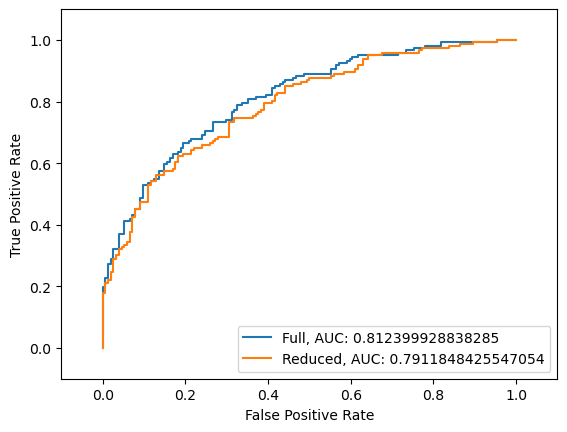

In [108]:
fpr_f, tpr_f, thresholds_f = roc_curve(yf_test, yprob_full)#, drop_intermediate=False)
roc_auc_f = auc(fpr_f, tpr_f)

fpr_r, tpr_r, thresholds_r = roc_curve(yr_test, yprob_reduced)#, drop_intermediate=False)
roc_auc_r = auc(fpr_r, tpr_r)

plt.plot(fpr_f, tpr_f, label='Full, AUC: '+ str(roc_auc_f))
plt.plot(fpr_r, tpr_r, label='Reduced, AUC: '+ str(roc_auc_r))
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()

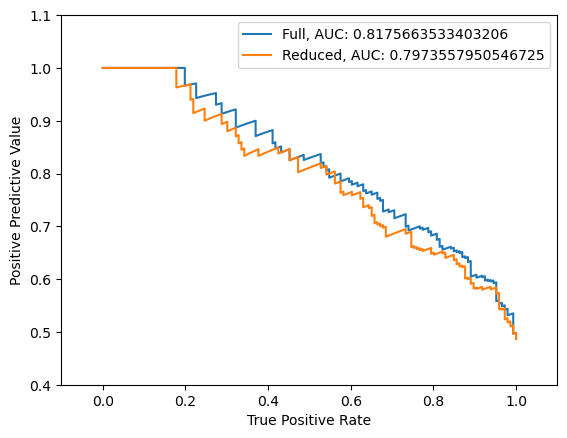

In [112]:
precision_f, recall_f, _f = precision_recall_curve(yf_test, yprob_full)
precision_r, recall_r, _r = precision_recall_curve(yr_test, yprob_reduced)

pr_auc_f = auc(recall_f, precision_f)
pr_auc_r = auc(recall_r, precision_r)

plt.plot(recall_f, precision_f, label='Full, AUC: '+ str(pr_auc_f))
plt.plot(recall_r, precision_r, label='Reduced, AUC: '+ str(pr_auc_r))
plt.xlim(-.1,1.1)
plt.ylim(.4,1.1)
plt.xlabel('True Positive Rate')
plt.ylabel('Positive Predictive Value')
plt.legend()

## 5) Interpretation

1. Which model has higher **ROC-AUC** and **PR-AUC**? What does this imply about `PWAT`?  

The model including CAPE, PWAT, and shear has the greater ROC and PR AUC. This means that PWAT alone does not make as accurate predictions as including other variables such as CAPE and shear. Thus, CAPE and shear contain information that helps the model distiquish between different outcomes when it makes its predictions.

2. Compare **accuracy**, **precision**, and **recall** for both models.  
   - Which model would you choose to **maximize event detection** (recall)?  

      I would choose the model with CAPE, PWAT, and shear

   - Which model would you choose to **minimize false alarms** (precision)?  

      I would choose the model with only PWAT